## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [1]:
import torchvision
from torchvision import datasets, transforms

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


In [2]:
classes = test_data.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## 6. Visualize at least 5 different samples of the MNIST training dataset.

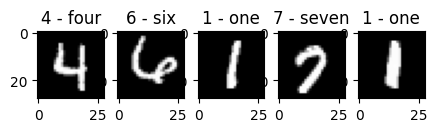

In [3]:
import matplotlib.pyplot as plt
import torch

fig = plt.figure(figsize=(5,5))
for i in range(5):
    idx_to_show = torch.randint(0, len(train_data), size=[1]).item()
    plt.subplot(1,5,i+1)
    plt.imshow(train_data.data[idx_to_show], cmap='gray')
    plt.title(train_data.classes[train_data.targets[idx_to_show]])

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
import torch.nn as nn

class model_2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  dilation=1,
                  bias=True,
                  device=device),
        nn.ReLU()
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  dilation=1,
                  bias=True,
                  device=device),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  dilation=1,
                  bias=True,
                  device=device),
        nn.ReLU()
    )
    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  dilation=1,
                  bias=True,
                  device=device
    ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
              out_features=output_shape,
              device=device)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.conv_block_4(x)
    x = self.classifier(x)
    return x

In [7]:
X, y = next(iter(train_dataloader))
X, y = X.to(device), y.to(device)
model = model_2(input_shape=1, hidden_units=10, output_shape=10).to(device)
yHat = model(X)
yHat.shape

torch.Size([32, 10])

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [8]:
from tqdm.auto import tqdm
from time import time
epochnum = 5

model = model_2(1,10,10).to(device)
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

start_time = time()

for epochi in tqdm(range(epochnum), desc="Epoch Loop"):
  trainloss, testloss = 0, 0
  trainacc, testacc = 0, 0
  model.train()
  for X, y in tqdm(train_dataloader,desc="Train Loop"):
    X, y = X.to(device), y.to(device)
    yHat = model(X)
    loss = lossfunc(yHat, y)
    trainloss += loss.item()
    trainacc += 100 * (yHat.argmax(dim=1) == y).sum().item()/len(yHat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  trainloss /= len(train_dataloader)
  trainacc /= len(train_dataloader)

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Test Loop"):
      X, y = X.to(device), y.to(device)
      yHat = model(X)
      loss = lossfunc(yHat, y)
      testloss += loss.item()
      testacc += 100 * (yHat.argmax(dim=1) == y).sum().item()/len(yHat)

  testloss /= len(test_dataloader)
  testacc /= len(test_dataloader)


  elapsed_time = time() - start_time

  print(f'Epoch {epochi}: Train Acc: {trainacc} | Test Acc: {testacc} | Train Loss: {trainloss} | Test Loss: {testloss} | Time: {elapsed_time}')



Epoch Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loop:   0%|          | 0/1875 [00:00<?, ?it/s]

Test Loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: Train Acc: 87.65 | Test Acc: 97.54392971246007 | Train Loss: 0.36917680780241885 | Test Loss: 0.07580970480103423 | Time: 12.467765808105469


Train Loop:   0%|          | 0/1875 [00:00<?, ?it/s]

Test Loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Train Acc: 97.73333333333333 | Test Acc: 98.3326677316294 | Train Loss: 0.07424903288233715 | Test Loss: 0.05214517045198544 | Time: 24.48142910003662


Train Loop:   0%|          | 0/1875 [00:00<?, ?it/s]

Test Loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Train Acc: 98.21333333333334 | Test Acc: 98.31269968051119 | Train Loss: 0.05833515336480923 | Test Loss: 0.049128435126651035 | Time: 36.85602426528931


Train Loop:   0%|          | 0/1875 [00:00<?, ?it/s]

Test Loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Train Acc: 98.49333333333334 | Test Acc: 98.10303514376997 | Train Loss: 0.04762121322780149 | Test Loss: 0.05746705545539843 | Time: 50.764320611953735


Train Loop:   0%|          | 0/1875 [00:00<?, ?it/s]

Test Loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Train Acc: 98.765 | Test Acc: 98.79193290734824 | Train Loss: 0.04088762652986528 | Test Loss: 0.04004272600723663 | Time: 62.98531889915466


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

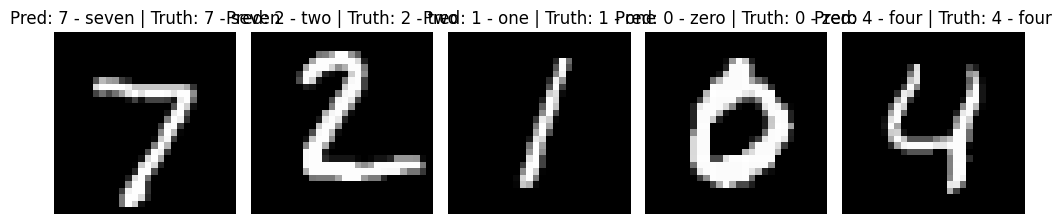

In [9]:
fig = plt.figure(figsize=(10,10))
model.eval()
with torch.inference_mode():
  X, y = next(iter(test_dataloader))
  X, y = X.to(device), y.to(device)
  yHat = model(X)

  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i].cpu().permute(1,2,0), cmap='gray')
    plt.axis("off")
    plt.title(f'Pred: {classes[yHat[i].argmax(dim=0)]} | Truth: {classes[y[i]]}')
    plt.tight_layout()





## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [59]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

# 1. Make predictions with trained model and update confusion matrix

confMat = ConfusionMatrix(task='multiclass', num_classes=len(test_data.classes)).to(device) # Initialize confusion matrix on the same device as the model

model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Update confusion matrix with batch predictions and targets
    confMat.update(y_pred, y)

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

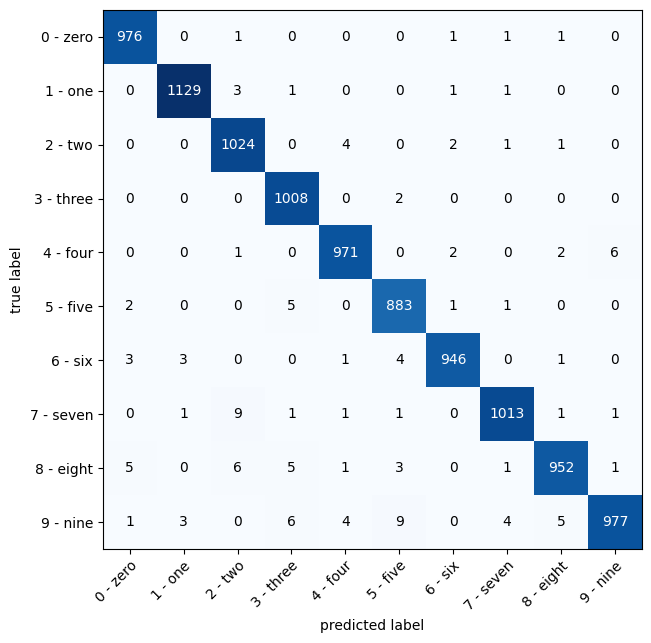

In [60]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confMat.compute().cpu().numpy(), # matplotlib likes working with numpy
    class_names=test_data.classes, # list of class names
    figsize=(10, 7)
)

In [14]:
import torch

class_counts = torch.bincount(test_data.targets)
for i in range(len(test_data.classes)):
  print(f'Class: {test_data.classes[i]} | Count: {class_counts[i]}')

Class: 0 - zero | Count: 980
Class: 1 - one | Count: 1135
Class: 2 - two | Count: 1032
Class: 3 - three | Count: 1010
Class: 4 - four | Count: 982
Class: 5 - five | Count: 892
Class: 6 - six | Count: 958
Class: 7 - seven | Count: 1028
Class: 8 - eight | Count: 974
Class: 9 - nine | Count: 1009


## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [25]:
X = torch.randn(size=(1,3,64,64))
y = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=3,padding=0)(X)
y.shape

torch.Size([1, 10, 21, 21])

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [32]:
fashion_dataset = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [104]:
class_counts = torch.bincount(fashion_dataset.targets)
for i in range(len(fashion_dataset.classes)):
  print(f'Class: {fashion_dataset.classes[i]} | Count: {class_counts[i]}')

Class: T-shirt/top | Count: 1000
Class: Trouser | Count: 1000
Class: Pullover | Count: 1000
Class: Dress | Count: 1000
Class: Coat | Count: 1000
Class: Sandal | Count: 1000
Class: Shirt | Count: 1000
Class: Sneaker | Count: 1000
Class: Bag | Count: 1000
Class: Ankle boot | Count: 1000


In [33]:
fashion_dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [105]:
model.eval()
y_preds = []
with torch.inference_mode():
  for X, y in tqdm(fashion_dataset, desc="Making predictions..."):
    X = X.to(device)
    yHat = model(X.unsqueeze(0))
    y_preds.append(yHat.argmax(dim=1))

y_preds = torch.cat(y_preds)

Making predictions...:   0%|          | 0/10000 [00:00<?, ?it/s]

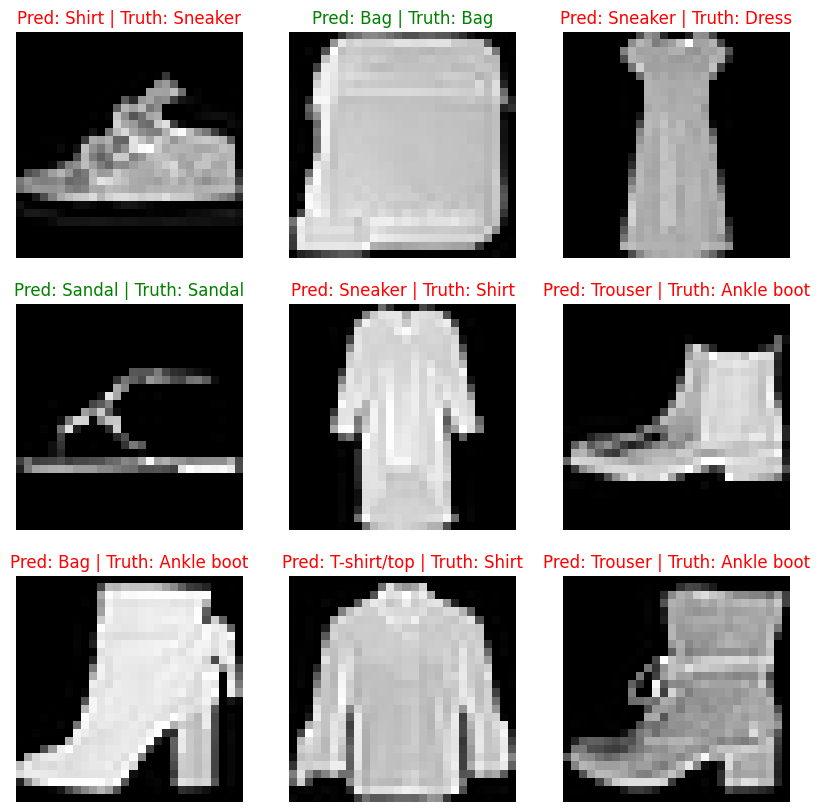

In [106]:
fig = plt.figure(figsize=(10,10))

for i in range(9):
  plt.subplot(3,3,i+1)
  rand_idx = torch.randint(0, len(fashion_dataset), size=[1]).item()
  plt.imshow(fashion_dataset.data[rand_idx], cmap='gray')
  colors = 'green' if y_preds[rand_idx] == fashion_dataset.targets[rand_idx] else 'red'
  plt.title(f'Pred: {fashion_dataset.classes[y_preds[rand_idx]]} | Truth: {fashion_dataset.classes[fashion_dataset.targets[rand_idx]]}',c=colors)
  plt.axis("off")

In [114]:
confMat_fashion = ConfusionMatrix(task='multiclass', num_classes=len(fashion_dataset.classes))
confMat_fashion.update(y_preds.cpu(), fashion_dataset.targets)

In [116]:
confMat_fashion.compute()

tensor([[  8,   6,  69,  33,  38,   7,   6, 594, 226,  13],
        [  0,  61,  19,   0, 241,   0,   0, 551, 103,  25],
        [106,   4, 160,  30,  19,   0, 168, 133, 336,  44],
        [ 14, 185, 173,  17,  91,   4,   9, 331, 152,  24],
        [203,   7, 200,   8,  26,   0, 134,  83, 291,  48],
        [ 84,  19, 563,  30,  61, 188,   6,   8,  41,   0],
        [ 96,   9, 183,  24,  61,   1,  48, 275, 279,  24],
        [148,  20, 765,   0,  46,   4,   6,   5,   6,   0],
        [235,  40, 348,  18,  61,   1,   3,  60, 230,   4],
        [ 72, 539, 264,  11,   4,   5,   1,   0, 104,   0]])

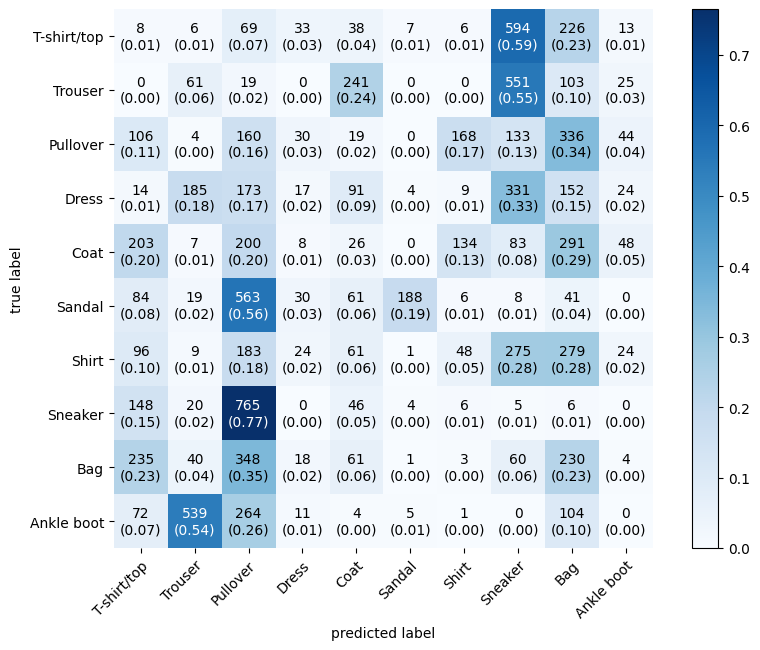

In [124]:
fig, ax = plot_confusion_matrix(
    conf_mat=confMat_fashion.compute().numpy(),
    hide_spines=True,
    cmap = 'Blues',
    figsize=(10, 7),
    class_names=fashion_dataset.classes,
    colorbar = True,
    show_normed=True
)